In [1]:
#importing necessary library
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt 
import time 
from collections import Counter
import os
%matplotlib inline

In [2]:
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing 
from sklearn import tree
from sklearn import linear_model
from imblearn.under_sampling import RandomUnderSampler

In [3]:
#Block warnings
import warnings 
warnings.filterwarnings('ignore')

In [4]:
# loading the dataset
traffic_data = pd.read_csv('C://Users//getac//Documents//Thesis file//RTA_clean_data.csv',header=0)
traffic_data.head()

hour  minute  Day_of_week  Age_band_of_driver  Sex_of_driver  \
0    17       2            1                   0              1   
1    17       2            1                   1              1   
2    17       2            1                   0              1   
3     1       6            3                   0              1   
4     1       6            3                   0              1   

   Educational_level  Vehicle_driver_relation  Driving_experience  \
0                  0                        0                   0   
1                  4                        0                   3   
2                  4                        0                   0   
3                  4                        0                   2   
4                  4                        0                   1   

   Type_of_vehicle  Owner_of_vehicle  ...  Vehicle_movement  \
0                0                 3  ...                 2   
1               11                 3  ...                 2   
2                5                 3  ...                 2   
3               11                 0  ...                 2   
4               17                 3  ...                 2   

   Pedestrian_movement  Cause_of_accident  Accident_severity  cluster_label  \
0                    7                 10                  2              1   
1                    7                 18                  2              1   
2                    7                  0                  1              2   
3                    7                  1                  2              0   
4                    7                 18                  2              0   

   cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  
0        0.0        1.0        0.0        0.0        0.0  
1        0.0        1.0        0.0        0.0        0.0  
2        0.0        0.0        1.0        0.0        0.0  
3        1.0        0.0        0.0        0.0        0.0  
4        1.0        0.0        0.0        0.0        0.0  

[5 rows x 32 columns]

In [5]:
# RTA_Data = data_combined.copy()
# RTA_Data.to_csv('C://Users//getac//Documents//Thesis file//RTA_clean_data.csv',index=False)

In [6]:
#separating dependant and independant variable
X = traffic_data.drop('Accident_severity', axis=1)
y = traffic_data['Accident_severity']

In [7]:
X.shape, y.shape

((13063, 31), (13063,))

In [8]:
# Class Balancing with SMOTETomek link
from imblearn.combine import SMOTETomek  
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

In [9]:
pd.get_dummies(traffic_data,drop_first=True).shape
X_resampled = pd.get_dummies(X_resampled, drop_first=True)

In [10]:
X_resampled.shape

(32322, 31)

In [11]:
## train test split
from sklearn.model_selection import cross_val_score, train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)


#  1. KXGB Model 

## A. Impact of Varying Learning rate

#### i. Using learning rate 0.01

In [13]:
# Import necessary libraries for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Hyperparameter Tuning using GridSearchCV for XGBoost
param_grid_kxgb1 = {
    'booster': ['gbtree'],
    'max_depth': [5,10,15,20],
    'learning_rate': [0.01],
    'n_estimators': [100, 300, 500,700,1000],
    'objective': ['multi:softmax', 'multi:softprob'],
    'num_class': [3],
    'random_state': [42],
    'nthread': [6],
}
# Create an KXGBoost classifier
kxgb_model = xgb.XGBClassifier()

# Perform GridSearchCV with k-fold cross-validation
grid_search_kxgb = GridSearchCV(
    estimator=kxgb_model,
    param_grid = param_grid_kxgb1,
    cv=5,
    scoring='f1_macro',
    verbose=5,
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search_kxgb.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'booster': ['gbtree'], 'learning_rate': [0.01],
                         'max_depth': [5, 10, 15, 20],
                         'n_estimators': [100, 300, 500, 700, 1000],
                         'nthread': [6], 'num_class': [3],
                         'objective': ['multi:softmax', 'multi:softprob'],
                         'random_state': [42]},
             scoring='f1_macro', verbose=5)

In [14]:
# Get the best hyperparameters and the corresponding model
best_params_kxgb = grid_search_kxgb.best_params_
best_model_kxgb = grid_search_kxgb.best_estimator_

# Train the best model on the full training set
best_model_kxgb.fit(
    X_train, 
    y_train, 
    early_stopping_rounds=20,
    eval_set=[(X_test, y_test)],
    eval_metric="mlogloss", 
    verbose=True
)

# Printing the best hyperparameters
print('The best hyperparameters are:\n', grid_search_kxgb.best_params_)

[0]	validation_0-mlogloss:1.08518
[1]	validation_0-mlogloss:1.07200
[2]	validation_0-mlogloss:1.05904
[3]	validation_0-mlogloss:1.04633
[4]	validation_0-mlogloss:1.03381
[5]	validation_0-mlogloss:1.02151
[6]	validation_0-mlogloss:1.00943
[7]	validation_0-mlogloss:0.99753
[8]	validation_0-mlogloss:0.98585
[9]	validation_0-mlogloss:0.97436
[10]	validation_0-mlogloss:0.96306
[11]	validation_0-mlogloss:0.95195
[12]	validation_0-mlogloss:0.94102
[13]	validation_0-mlogloss:0.93025
[14]	validation_0-mlogloss:0.91965
[15]	validation_0-mlogloss:0.90925
[16]	validation_0-mlogloss:0.89899
[17]	validation_0-mlogloss:0.88891
[18]	validation_0-mlogloss:0.87898
[19]	validation_0-mlogloss:0.86917
[20]	validation_0-mlogloss:0.85953
[21]	validation_0-mlogloss:0.85004
[22]	validation_0-mlogloss:0.84064
[23]	validation_0-mlogloss:0.83139
[24]	validation_0-mlogloss:0.82231
[25]	validation_0-mlogloss:0.81331
[26]	validation_0-mlogloss:0.80447
[27]	validation_0-mlogloss:0.79573
[28]	validation_0-mlogloss:0.7

[231]	validation_0-mlogloss:0.14834
[232]	validation_0-mlogloss:0.14748
[233]	validation_0-mlogloss:0.14662
[234]	validation_0-mlogloss:0.14577
[235]	validation_0-mlogloss:0.14493
[236]	validation_0-mlogloss:0.14410
[237]	validation_0-mlogloss:0.14327
[238]	validation_0-mlogloss:0.14245
[239]	validation_0-mlogloss:0.14165
[240]	validation_0-mlogloss:0.14085
[241]	validation_0-mlogloss:0.14006
[242]	validation_0-mlogloss:0.13928
[243]	validation_0-mlogloss:0.13850
[244]	validation_0-mlogloss:0.13774
[245]	validation_0-mlogloss:0.13698
[246]	validation_0-mlogloss:0.13623
[247]	validation_0-mlogloss:0.13548
[248]	validation_0-mlogloss:0.13475
[249]	validation_0-mlogloss:0.13402
[250]	validation_0-mlogloss:0.13331
[251]	validation_0-mlogloss:0.13260
[252]	validation_0-mlogloss:0.13189
[253]	validation_0-mlogloss:0.13120
[254]	validation_0-mlogloss:0.13051
[255]	validation_0-mlogloss:0.12983
[256]	validation_0-mlogloss:0.12915
[257]	validation_0-mlogloss:0.12849
[258]	validation_0-mlogloss:

[459]	validation_0-mlogloss:0.06606
[460]	validation_0-mlogloss:0.06596
[461]	validation_0-mlogloss:0.06587
[462]	validation_0-mlogloss:0.06577
[463]	validation_0-mlogloss:0.06567
[464]	validation_0-mlogloss:0.06558
[465]	validation_0-mlogloss:0.06547
[466]	validation_0-mlogloss:0.06538
[467]	validation_0-mlogloss:0.06528
[468]	validation_0-mlogloss:0.06518
[469]	validation_0-mlogloss:0.06509
[470]	validation_0-mlogloss:0.06500
[471]	validation_0-mlogloss:0.06491
[472]	validation_0-mlogloss:0.06482
[473]	validation_0-mlogloss:0.06472
[474]	validation_0-mlogloss:0.06463
[475]	validation_0-mlogloss:0.06453
[476]	validation_0-mlogloss:0.06444
[477]	validation_0-mlogloss:0.06435
[478]	validation_0-mlogloss:0.06426
[479]	validation_0-mlogloss:0.06417
[480]	validation_0-mlogloss:0.06409
[481]	validation_0-mlogloss:0.06400
[482]	validation_0-mlogloss:0.06391
[483]	validation_0-mlogloss:0.06383
[484]	validation_0-mlogloss:0.06374
[485]	validation_0-mlogloss:0.06365
[486]	validation_0-mlogloss:

[687]	validation_0-mlogloss:0.05485
[688]	validation_0-mlogloss:0.05483
[689]	validation_0-mlogloss:0.05481
[690]	validation_0-mlogloss:0.05480
[691]	validation_0-mlogloss:0.05478
[692]	validation_0-mlogloss:0.05477
[693]	validation_0-mlogloss:0.05475
[694]	validation_0-mlogloss:0.05473
[695]	validation_0-mlogloss:0.05472
[696]	validation_0-mlogloss:0.05469
[697]	validation_0-mlogloss:0.05468
[698]	validation_0-mlogloss:0.05466
[699]	validation_0-mlogloss:0.05464
[700]	validation_0-mlogloss:0.05462
[701]	validation_0-mlogloss:0.05461
[702]	validation_0-mlogloss:0.05459
[703]	validation_0-mlogloss:0.05458
[704]	validation_0-mlogloss:0.05456
[705]	validation_0-mlogloss:0.05454
[706]	validation_0-mlogloss:0.05453
[707]	validation_0-mlogloss:0.05450
[708]	validation_0-mlogloss:0.05449
[709]	validation_0-mlogloss:0.05446
[710]	validation_0-mlogloss:0.05444
[711]	validation_0-mlogloss:0.05442
[712]	validation_0-mlogloss:0.05440
[713]	validation_0-mlogloss:0.05438
[714]	validation_0-mlogloss:

[915]	validation_0-mlogloss:0.05300
[916]	validation_0-mlogloss:0.05300
[917]	validation_0-mlogloss:0.05300
[918]	validation_0-mlogloss:0.05300
[919]	validation_0-mlogloss:0.05300
[920]	validation_0-mlogloss:0.05300
[921]	validation_0-mlogloss:0.05300
[922]	validation_0-mlogloss:0.05300
[923]	validation_0-mlogloss:0.05300
[924]	validation_0-mlogloss:0.05300
[925]	validation_0-mlogloss:0.05299
[926]	validation_0-mlogloss:0.05299
[927]	validation_0-mlogloss:0.05298
[928]	validation_0-mlogloss:0.05298
[929]	validation_0-mlogloss:0.05298
[930]	validation_0-mlogloss:0.05298
[931]	validation_0-mlogloss:0.05297
[932]	validation_0-mlogloss:0.05297
[933]	validation_0-mlogloss:0.05297
[934]	validation_0-mlogloss:0.05297
[935]	validation_0-mlogloss:0.05297
[936]	validation_0-mlogloss:0.05297
[937]	validation_0-mlogloss:0.05296
[938]	validation_0-mlogloss:0.05296
[939]	validation_0-mlogloss:0.05296
[940]	validation_0-mlogloss:0.05296
[941]	validation_0-mlogloss:0.05296
[942]	validation_0-mlogloss:

In [15]:
# Predict on the testing set
y_pred_kxgb = best_model_kxgb.predict(X_test)

Confusion Matrix:
[[2112    9   22]
 [   1 2157   38]
 [  15    7 2104]]


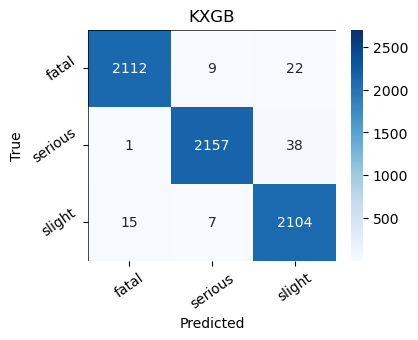

In [16]:
# plot a Confusion Matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

# Class names
class_names = ['fatal', 'serious', 'slight']

# Confusion Matrix
#custom_cmap = LinearSegmentedColormap.from_list('custom', ['#989b9e', '#36109e','#63109e'])
cm = confusion_matrix(y_test, y_pred_kxgb)
print("Confusion Matrix:")
print(cm)


plt.figure(figsize=(4, 3))

# Plot the outer boundary
plt.plot([0, len(class_names)], [0, 0], color='black', linewidth=0.5)
plt.plot([0, 0], [0, len(class_names)], color='black', linewidth=0.5)
plt.plot([len(class_names), len(class_names)], [0, len(class_names)], color='black', linewidth=0.5)
plt.plot([0, len(class_names)], [len(class_names), len(class_names)], color='black', linewidth=0.5)

# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',vmax=2700)
plt.gca().set_frame_on(False)

# Rotate the class names by 35 degrees
plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=35)
plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=35)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KXGB')
plt.show()

In [17]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
print("Classification Report:")
print(classification_report(y_test, y_pred_kxgb, target_names=class_names))
print('Accuracy:', accuracy_score(y_test, y_pred_kxgb))
print("Recall:", recall_score(y_test, y_pred_kxgb, average='macro'))
print("Precision:", precision_score(y_test, y_pred_kxgb, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred_kxgb, average='macro'))


Classification Report:
              precision    recall  f1-score   support

       fatal       0.99      0.99      0.99      2143
     serious       0.99      0.98      0.99      2196
      slight       0.97      0.99      0.98      2126

    accuracy                           0.99      6465
   macro avg       0.99      0.99      0.99      6465
weighted avg       0.99      0.99      0.99      6465

Accuracy: 0.9857695282289249
Recall: 0.985808887792063
Precision: 0.9858888586780925
F1 score: 0.9857642130713741


In [18]:
# Perform cross-validation for the best model
from sklearn.model_selection import cross_val_score
cv_scores_kxgb = cross_val_score(best_model_kxgb, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (XGBoost): {cv_scores_kxgb}")
print(f"Mean Cross-Validation Accuracy (XGBoost): {cv_scores_kxgb.mean()}")


Cross-Validation Accuracy (XGBoost): [0.98762568 0.98472544 0.98510926 0.98568942 0.98762328]
Mean Cross-Validation Accuracy (XGBoost): 0.9861546180188968


In [19]:
# Saving the best model
import joblib
joblib.dump(best_model_kxgb, 'C:\\Users\\getac\\Documents\\Thesis file\\Project\\model\\best_KXGB_model.pkl')


['C:\\Users\\getac\\Documents\\Thesis file\\Project\\model\\best_KXGB_model.pkl']

#### ii. Using learning rate 0.1

In [20]:
# Import necessary libraries for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Hyperparameter Tuning using GridSearchCV for XGBoost
param_grid_kxgb2 = {
    'booster': ['gbtree'],
    'max_depth': [5, 10, 15, 20],
    'learning_rate': [0.1],
    'n_estimators': [100, 300, 500,700,1000],
    'objective': ['multi:softmax', 'multi:softprob'],
    'num_class': [3],
    'random_state': [42],
    'nthread': [6],
}
# Create an KXGBoost classifier
kxgb_model = xgb.XGBClassifier()

# Perform GridSearchCV with k-fold cross-validation
grid_search_kxgb = GridSearchCV(
    estimator=kxgb_model,
    param_grid = param_grid_kxgb2,
    cv=5,
    scoring='f1_macro',
    verbose=5,
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search_kxgb.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'booster': ['gbtree'], 'learning_rate': [0.1],
                         'max_depth': [5, 10, 15, 20],
                         'n_estimators': [100, 300, 500, 700, 1000],
                         'nthread': [6], 'num_class': [3],
                         'objective': ['multi:softmax', 'multi:softprob'],
                         'random_state': [42]},
             scoring='f1_macro', verbose=5)

In [21]:
# Get the best hyperparameters and the corresponding model
best_params_kxgb2 = grid_search_kxgb.best_params_
best_model_kxgb2 = grid_search_kxgb.best_estimator_

# Train the best model on the full training set
best_model_kxgb2.fit(
    X_train, 
    y_train, 
    early_stopping_rounds=30,
    eval_set=[(X_test, y_test)],
    eval_metric="mlogloss", 
    verbose=True
)

# Printing the best hyperparameters
print('The best hyperparameters are:\n', grid_search_kxgb.best_params_)

[0]	validation_0-mlogloss:0.97003
[1]	validation_0-mlogloss:0.86276
[2]	validation_0-mlogloss:0.77187
[3]	validation_0-mlogloss:0.69324
[4]	validation_0-mlogloss:0.62525
[5]	validation_0-mlogloss:0.56623
[6]	validation_0-mlogloss:0.51444
[7]	validation_0-mlogloss:0.46852
[8]	validation_0-mlogloss:0.42799
[9]	validation_0-mlogloss:0.39212
[10]	validation_0-mlogloss:0.35966
[11]	validation_0-mlogloss:0.33101
[12]	validation_0-mlogloss:0.30514
[13]	validation_0-mlogloss:0.28194
[14]	validation_0-mlogloss:0.26099
[15]	validation_0-mlogloss:0.24216
[16]	validation_0-mlogloss:0.22524
[17]	validation_0-mlogloss:0.20997
[18]	validation_0-mlogloss:0.19618
[19]	validation_0-mlogloss:0.18357
[20]	validation_0-mlogloss:0.17231
[21]	validation_0-mlogloss:0.16201
[22]	validation_0-mlogloss:0.15280
[23]	validation_0-mlogloss:0.14429
[24]	validation_0-mlogloss:0.13626
[25]	validation_0-mlogloss:0.12908
[26]	validation_0-mlogloss:0.12231
[27]	validation_0-mlogloss:0.11632
[28]	validation_0-mlogloss:0.1

In [22]:
# Predict on the testing set
y_pred_kxgb2 = best_model_kxgb2.predict(X_test)

Confusion Matrix:
[[2114    9   20]
 [   3 2154   39]
 [  14    6 2106]]


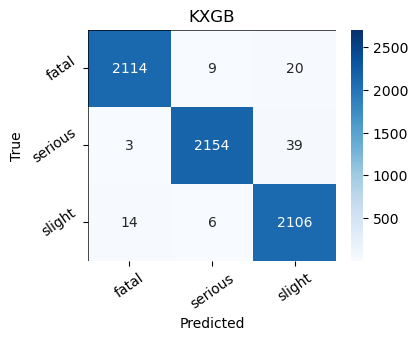

In [23]:
# plot a Confusion Matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

# Class names
class_names = ['fatal', 'serious', 'slight']

# Confusion Matrix
#custom_cmap = LinearSegmentedColormap.from_list('custom', ['#989b9e', '#36109e','#63109e'])
cm = confusion_matrix(y_test, y_pred_kxgb2)
print("Confusion Matrix:")
print(cm)


plt.figure(figsize=(4, 3))

# Plot the outer boundary
plt.plot([0, len(class_names)], [0, 0], color='black', linewidth=0.5)
plt.plot([0, 0], [0, len(class_names)], color='black', linewidth=0.5)
plt.plot([len(class_names), len(class_names)], [0, len(class_names)], color='black', linewidth=0.5)
plt.plot([0, len(class_names)], [len(class_names), len(class_names)], color='black', linewidth=0.5)

# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',vmax=2700)
plt.gca().set_frame_on(False)

# Rotate the class names by 35 degrees
plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=35)
plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=35)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KXGB')
plt.show()

In [24]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
print("Classification Report:")
print(classification_report(y_test, y_pred_kxgb2, target_names=class_names))
print('Accuracy:', accuracy_score(y_test, y_pred_kxgb2))
print("Recall:", recall_score(y_test, y_pred_kxgb2, average='macro'))
print("Precision:", precision_score(y_test, y_pred_kxgb2, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred_kxgb2, average='macro'))


Classification Report:
              precision    recall  f1-score   support

       fatal       0.99      0.99      0.99      2143
     serious       0.99      0.98      0.99      2196
      slight       0.97      0.99      0.98      2126

    accuracy                           0.99      6465
   macro avg       0.99      0.99      0.99      6465
weighted avg       0.99      0.99      0.99      6465

Accuracy: 0.9859242072699149
Recall: 0.9859781826817371
Precision: 0.9860449135121265
F1 score: 0.9859227341138975


In [25]:
# Perform cross-validation for the best model
from sklearn.model_selection import cross_val_score
cv_scores_kxgb2 = cross_val_score(best_model_kxgb2, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (XGBoost): {cv_scores_kxgb2}")
print(f"Mean Cross-Validation Accuracy (XGBoost): {cv_scores_kxgb2.mean()}")

Cross-Validation Accuracy (XGBoost): [0.98820572 0.98607889 0.98704313 0.98762328 0.98762328]
Mean Cross-Validation Accuracy (XGBoost): 0.9873148603902753


In [31]:
# Saving the best model
import joblib
joblib.dump(best_model_kxgb, 'C:\\Users\\getac\\Documents\\Thesis file\\Project\\model\\best_KXGB_model2.pkl')


['C:\\Users\\getac\\Documents\\Thesis file\\Project\\model\\best_KXGB_model2.pkl']

### iiI. using learning rate 0.3

In [38]:
# Import necessary libraries for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Hyperparameter Tuning using GridSearchCV for XGBoost
param_grid_kxgb3 = {
    'booster': ['gbtree'],
    'max_depth': [5, 10, 15, 20],
    'learning_rate': [0.3],
    'n_estimators': [100, 300,500, 700, 1000],
    'objective': ['multi:softmax', 'multi:softprob'],
    'num_class': [3],
    'random_state': [42],
    'nthread': [6],
}

# Create an KXGBoost classifier
kxgb_model3 = xgb.XGBClassifier()

# Perform GridSearchCV with k-fold cross-validation
grid_search_kxgb = GridSearchCV(
    estimator=kxgb_model3,
    param_grid = param_grid_kxgb3,
    cv=5,
    scoring='f1_macro',
    verbose=5,
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search_kxgb.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'booster': ['gbtree'], 'learning_rate': [0.3],
                         'max_depth': [5, 10, 15, 20],
                         'n_estimators': [100, 300, 500, 700, 1000],
                         'nthread': [6], 'num_class': [3],
                         'objective': ['multi:softmax', 'multi:softprob'],
                         'random_state': [42]},
             scoring='f1_macro', verbose=5)

In [39]:
# Get the best hyperparameters and the corresponding model
best_params_kxgb = grid_search_kxgb.best_params_
best_model_kxgb = grid_search_kxgb.best_estimator_

# Train the best model on the full training set
best_model_kxgb.fit(
    X_train, 
    y_train, 
    early_stopping_rounds=10,
    eval_set=[(X_test, y_test)],
    eval_metric="mlogloss", 
    verbose=True
)

# Printing the best hyperparameters
print('The best hyperparameters are:\n', grid_search_kxgb.best_params_)

[0]	validation_0-mlogloss:0.74162
[1]	validation_0-mlogloss:0.53349
[2]	validation_0-mlogloss:0.39856
[3]	validation_0-mlogloss:0.30546
[4]	validation_0-mlogloss:0.24012
[5]	validation_0-mlogloss:0.19288
[6]	validation_0-mlogloss:0.15813
[7]	validation_0-mlogloss:0.13228
[8]	validation_0-mlogloss:0.11356
[9]	validation_0-mlogloss:0.09910
[10]	validation_0-mlogloss:0.08832
[11]	validation_0-mlogloss:0.08005
[12]	validation_0-mlogloss:0.07337
[13]	validation_0-mlogloss:0.06839
[14]	validation_0-mlogloss:0.06480
[15]	validation_0-mlogloss:0.06231
[16]	validation_0-mlogloss:0.06008
[17]	validation_0-mlogloss:0.05850
[18]	validation_0-mlogloss:0.05719
[19]	validation_0-mlogloss:0.05615
[20]	validation_0-mlogloss:0.05543
[21]	validation_0-mlogloss:0.05479
[22]	validation_0-mlogloss:0.05434
[23]	validation_0-mlogloss:0.05409
[24]	validation_0-mlogloss:0.05382
[25]	validation_0-mlogloss:0.05355
[26]	validation_0-mlogloss:0.05340
[27]	validation_0-mlogloss:0.05328
[28]	validation_0-mlogloss:0.0

In [40]:
# Predict on the testing set
y_pred_kxgb = best_model_kxgb.predict(X_test)

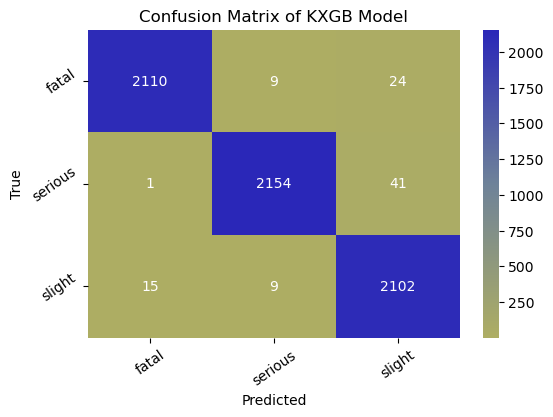

In [41]:
# plot a Confusion Matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
# Class names
class_names = ['fatal', 'serious', 'slight']
custom_cmap = LinearSegmentedColormap.from_list('custom', ["#adad63", "#6e8299", "#2a27b8"])
cm = confusion_matrix(y_test, y_pred_kxgb)
plt.figure(figsize=(6, 4))
# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap)

# Rotate the class names by 35 degrees
plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=35)
plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=35)
#plot the confusion matrix
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of KXGB Model')
plt.show()

In [42]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
print("Classification Report:")
print(classification_report(y_test, y_pred_kxgb, target_names=class_names))
print('Accuracy:', accuracy_score(y_test, y_pred_kxgb))
print("Recall:", recall_score(y_test, y_pred_kxgb, average='macro'))
print("Precision:", precision_score(y_test, y_pred_kxgb, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred_kxgb, average='macro'))


Classification Report:
              precision    recall  f1-score   support

       fatal       0.99      0.98      0.99      2143
     serious       0.99      0.98      0.99      2196
      slight       0.97      0.99      0.98      2126

    accuracy                           0.98      6465
   macro avg       0.98      0.98      0.98      6465
weighted avg       0.98      0.98      0.98      6465

Accuracy: 0.9846867749419954
Recall: 0.9847288460900029
Precision: 0.9848264464002592
F1 score: 0.9846847383671292


In [43]:
# Perform cross-validation for the best model
from sklearn.model_selection import cross_val_score
cv_scores_kxgb = cross_val_score(best_model_kxgb, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (XGBoost): {cv_scores_kxgb}")
print(f"Mean Cross-Validation Accuracy (XGBoost): {cv_scores_kxgb.mean()}")

Cross-Validation Accuracy (XGBoost): [0.98859242 0.98627224 0.98723651 0.98723651 0.98684974]
Mean Cross-Validation Accuracy (XGBoost): 0.9872374834787918


In [44]:
# Saving the best model
import joblib
joblib.dump(best_model_kxgb, 'C:\\Users\\getac\\Documents\\Thesis file\\Project\\model\\best_KXGB_model3.pkl')


['C:\\Users\\getac\\Documents\\Thesis file\\Project\\model\\best_KXGB_model3.pkl']

## B. Impacts of Varying booster function

### i. Using booster function dart

In [26]:
# Import necessary libraries for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Hyperparameter Tuning using GridSearchCV for XGBoost
param_grid_kxgb4 = {
    'booster': ['dart'],
    'max_depth': [5, 10, 15, 20],
    'learning_rate': [0.1],
    'n_estimators': [100, 300,500, 700, 1000],
    'objective': ['multi:softmax', 'multi:softprob'],
    'num_class': [3],
    'random_state': [42],
    'nthread': [6],
}

# Create an KXGBoost classifier
kxgb_model4 = xgb.XGBClassifier()

# Perform GridSearchCV with k-fold cross-validation
grid_search_kxgb = GridSearchCV(
    estimator=kxgb_model4,
    param_grid = param_grid_kxgb4,
    cv=5,
    scoring='f1_macro',
    verbose=5,
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search_kxgb.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'booster': ['dart'], 'learning_rate': [0.1],
                         'max_depth': [5, 10, 15, 20],
                         'n_estimators': [100, 300, 500, 700, 1000],
                         'nthread': [6], 'num_class': [3],
                         'objective': ['multi:softmax', 'multi:softprob'],
                         'random_state': [42]},
             scoring='f1_macro', verbose=5)

In [44]:
# Get the best hyperparameters and the corresponding model
best_params_kxgb4 = grid_search_kxgb.best_params_
best_model_kxgb4= grid_search_kxgb.best_estimator_

# Train the best model on the full training set
best_model_kxgb4.fit(
    X_train, 
    y_train, 
    early_stopping_rounds=10,
    eval_set=[(X_test, y_test)],
    eval_metric="mlogloss", 
    verbose=True
)

# Printing the best hyperparameters
print('The best hyperparameters are:\n', grid_search_kxgb.best_params_)

[0]	validation_0-mlogloss:0.97003
[1]	validation_0-mlogloss:0.86276
[2]	validation_0-mlogloss:0.77187
[3]	validation_0-mlogloss:0.69324
[4]	validation_0-mlogloss:0.62525
[5]	validation_0-mlogloss:0.56623
[6]	validation_0-mlogloss:0.51444
[7]	validation_0-mlogloss:0.46852
[8]	validation_0-mlogloss:0.42799
[9]	validation_0-mlogloss:0.39212
[10]	validation_0-mlogloss:0.35966
[11]	validation_0-mlogloss:0.33101
[12]	validation_0-mlogloss:0.30514
[13]	validation_0-mlogloss:0.28194
[14]	validation_0-mlogloss:0.26099
[15]	validation_0-mlogloss:0.24216
[16]	validation_0-mlogloss:0.22524
[17]	validation_0-mlogloss:0.20997
[18]	validation_0-mlogloss:0.19618
[19]	validation_0-mlogloss:0.18357
[20]	validation_0-mlogloss:0.17231
[21]	validation_0-mlogloss:0.16201
[22]	validation_0-mlogloss:0.15280
[23]	validation_0-mlogloss:0.14429
[24]	validation_0-mlogloss:0.13626
[25]	validation_0-mlogloss:0.12908
[26]	validation_0-mlogloss:0.12231
[27]	validation_0-mlogloss:0.11632
[28]	validation_0-mlogloss:0.1

In [32]:
# Predict on the testing set
y_pred_kxgb4 = best_model_kxgb4.predict(X_test)

Confusion Matrix:
[[2113    9   21]
 [   3 2154   39]
 [  14    6 2106]]


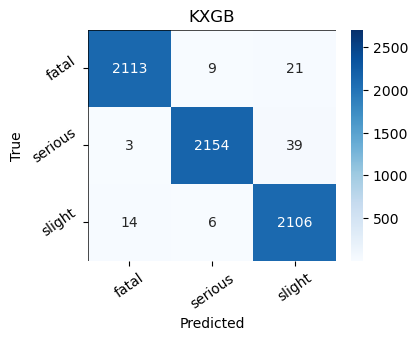

In [39]:
# plot a Confusion Matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

# Class names
class_names = ['fatal', 'serious', 'slight']

# Confusion Matrix
#custom_cmap = LinearSegmentedColormap.from_list('custom', ['#989b9e', '#36109e','#63109e'])
cm = confusion_matrix(y_test, y_pred_kxgb4)
print("Confusion Matrix:")
print(cm)


plt.figure(figsize=(4, 3))

# Plot the outer boundary
plt.plot([0, len(class_names)], [0, 0], color='black', linewidth=0.5)
plt.plot([0, 0], [0, len(class_names)], color='black', linewidth=0.5)
plt.plot([len(class_names), len(class_names)], [0, len(class_names)], color='black', linewidth=0.5)
plt.plot([0, len(class_names)], [len(class_names), len(class_names)], color='black', linewidth=0.5)

# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',vmax=2700)
plt.gca().set_frame_on(False)

# Rotate the class names by 35 degrees
plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=35)
plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=35)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KXGB')
plt.show()

In [40]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
print("Classification Report:")
print(classification_report(y_test, y_pred_kxgb4, target_names=class_names))
print('Accuracy:', accuracy_score(y_test, y_pred_kxgb4))
print("Recall:", recall_score(y_test, y_pred_kxgb4, average='macro'))
print("Precision:", precision_score(y_test, y_pred_kxgb4, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred_kxgb4, average='macro'))

Classification Report:
              precision    recall  f1-score   support

       fatal       0.99      0.99      0.99      2143
     serious       0.99      0.98      0.99      2196
      slight       0.97      0.99      0.98      2126

    accuracy                           0.99      6465
   macro avg       0.99      0.99      0.99      6465
weighted avg       0.99      0.99      0.99      6465

Accuracy: 0.9857695282289249
Recall: 0.9858226374958606
Precision: 0.9858959869111757
F1 score: 0.9857676512849011


In [41]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
print("Classification Report:")
print(classification_report(y_test, y_pred_kxgb4, target_names=class_names))
print('Accuracy:', accuracy_score(y_test, y_pred_kxgb4))
print("Recall:", recall_score(y_test, y_pred_kxgb4, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_kxgb4, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred_kxgb4, average='weighted'))

Classification Report:
              precision    recall  f1-score   support

       fatal       0.99      0.99      0.99      2143
     serious       0.99      0.98      0.99      2196
      slight       0.97      0.99      0.98      2126

    accuracy                           0.99      6465
   macro avg       0.99      0.99      0.99      6465
weighted avg       0.99      0.99      0.99      6465

Accuracy: 0.9857695282289249
Recall: 0.9857695282289249
Precision: 0.9858959869111757
F1 score: 0.985788863493183


In [17]:
# Perform cross-validation for the best model
from sklearn.model_selection import cross_val_score
cv_scores_kxgb4 = cross_val_score(best_model_kxgb4, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (KXGB): {cv_scores_kxgb4}")
print(f"Mean Cross-Validation Accuracy (KXGB): {cv_scores_kxgb4.mean()}")

Cross-Validation Accuracy (XGBoost): [0.98665893 0.98549884 0.98781667 0.98936376 0.98704313]
Mean Cross-Validation Accuracy (XGBoost): 0.9872762654120045


In [16]:
# Saving the best model
import joblib
joblib.dump(best_model_kxgb4, 'C:\\Users\\getac\\Documents\\Thesis file\\Project\\model\\best_KXGB_model4.pkl')

['C:\\Users\\getac\\Documents\\Thesis file\\Project\\model\\best_KXGB_model4.pkl']

### ii. Using Booster Function gblinear 

In [12]:
# Import necessary libraries for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Hyperparameter Tuning using GridSearchCV for XGBoost
param_grid_kxgb4 = {
    'booster': ['gblinear'],
    'max_depth': [5, 10, 15, 20],
    'learning_rate': [0.1],
    'n_estimators': [100, 300,500, 700, 1000],
    'objective': ['multi:softmax', 'multi:softprob'],
    'num_class': [3],
    'random_state': [42],
    'nthread': [6],
}

# Create an KXGBoost classifier
kxgb_model4 = xgb.XGBClassifier()

# Perform GridSearchCV with k-fold cross-validation
grid_search_kxgb = GridSearchCV(
    estimator=kxgb_model4,
    param_grid = param_grid_kxgb4,
    cv=5,
    scoring='f1_macro',
    verbose=5,
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search_kxgb.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[09:39:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.



GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'booster': ['gblinear'], 'learning_rate': [0.1],
                         'max_depth': [5, 10, 15, 20],
                         'n_estimators': [100, 300, 500, 700, 1000],
                         'nthread': [6], 'num_class': [3],
                         'objective': ['multi:softmax', 'multi:softprob'],
                         'random_state': [42]},
             scoring='f1_macro', verbose=5)

In [13]:
# Get the best hyperparameters and the corresponding model
best_params_kxgb = grid_search_kxgb.best_params_
best_model_kxgb = grid_search_kxgb.best_estimator_

# Train the best model on the full training set
best_model_kxgb.fit(
    X_train, 
    y_train, 
    early_stopping_rounds=10,
    eval_set=[(X_test, y_test)],
    eval_metric="mlogloss", 
    verbose=True
)

# Printing the best hyperparameters
print('The best hyperparameters are:\n', grid_search_kxgb.best_params_)

[09:39:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.

[0]	validation_0-mlogloss:1.03359
[1]	validation_0-mlogloss:0.97919
[2]	validation_0-mlogloss:0.93231
[3]	validation_0-mlogloss:0.89171
[4]	validation_0-mlogloss:0.85622
[5]	validation_0-mlogloss:0.82509
[6]	validation_0-mlogloss:0.79753
[7]	validation_0-mlogloss:0.77300
[8]	validation_0-mlogloss:0.75113
[9]	validation_0-mlogloss:0.73150
[10]	validation_0-mlogloss:0.71385
[11]	validation_0-mlogloss:0.69791
[12]	validation_0-mlogloss:0.68347
[13]	validation_0-mlogloss:0.67035
[14]	validation_0-mlogloss:0.65838
[15]	validation_0-mlogloss:0.64744
[16]	validation_0-mlogloss:0.63741
[17]	validation_0-mlogloss:0.62820
[18]	validation_0-mlogloss:0.61972
[19]	validation_0-mlogloss:0.61189
[20]	validation_0-mlogloss:0.60465
[21]	validation_0-mlogloss:0.59791
[22]	validation_0-mlogloss:0.59166
[23]	validation_0-mlogloss:0.58584
[24]	validation_0-mlogloss:

[227]	validation_0-mlogloss:0.41775
[228]	validation_0-mlogloss:0.41763
[229]	validation_0-mlogloss:0.41750
[230]	validation_0-mlogloss:0.41738
[231]	validation_0-mlogloss:0.41725
[232]	validation_0-mlogloss:0.41713
[233]	validation_0-mlogloss:0.41701
[234]	validation_0-mlogloss:0.41688
[235]	validation_0-mlogloss:0.41676
[236]	validation_0-mlogloss:0.41664
[237]	validation_0-mlogloss:0.41652
[238]	validation_0-mlogloss:0.41639
[239]	validation_0-mlogloss:0.41627
[240]	validation_0-mlogloss:0.41615
[241]	validation_0-mlogloss:0.41603
[242]	validation_0-mlogloss:0.41591
[243]	validation_0-mlogloss:0.41579
[244]	validation_0-mlogloss:0.41566
[245]	validation_0-mlogloss:0.41554
[246]	validation_0-mlogloss:0.41542
[247]	validation_0-mlogloss:0.41530
[248]	validation_0-mlogloss:0.41517
[249]	validation_0-mlogloss:0.41504
[250]	validation_0-mlogloss:0.41492
[251]	validation_0-mlogloss:0.41481
[252]	validation_0-mlogloss:0.41470
[253]	validation_0-mlogloss:0.41460
[254]	validation_0-mlogloss:

[455]	validation_0-mlogloss:0.39784
[456]	validation_0-mlogloss:0.39777
[457]	validation_0-mlogloss:0.39770
[458]	validation_0-mlogloss:0.39763
[459]	validation_0-mlogloss:0.39757
[460]	validation_0-mlogloss:0.39750
[461]	validation_0-mlogloss:0.39743
[462]	validation_0-mlogloss:0.39736
[463]	validation_0-mlogloss:0.39730
[464]	validation_0-mlogloss:0.39723
[465]	validation_0-mlogloss:0.39716
[466]	validation_0-mlogloss:0.39710
[467]	validation_0-mlogloss:0.39703
[468]	validation_0-mlogloss:0.39696
[469]	validation_0-mlogloss:0.39689
[470]	validation_0-mlogloss:0.39683
[471]	validation_0-mlogloss:0.39676
[472]	validation_0-mlogloss:0.39670
[473]	validation_0-mlogloss:0.39663
[474]	validation_0-mlogloss:0.39657
[475]	validation_0-mlogloss:0.39650
[476]	validation_0-mlogloss:0.39643
[477]	validation_0-mlogloss:0.39637
[478]	validation_0-mlogloss:0.39630
[479]	validation_0-mlogloss:0.39624
[480]	validation_0-mlogloss:0.39617
[481]	validation_0-mlogloss:0.39611
[482]	validation_0-mlogloss:

[683]	validation_0-mlogloss:0.38471
[684]	validation_0-mlogloss:0.38466
[685]	validation_0-mlogloss:0.38461
[686]	validation_0-mlogloss:0.38456
[687]	validation_0-mlogloss:0.38452
[688]	validation_0-mlogloss:0.38447
[689]	validation_0-mlogloss:0.38442
[690]	validation_0-mlogloss:0.38437
[691]	validation_0-mlogloss:0.38432
[692]	validation_0-mlogloss:0.38428
[693]	validation_0-mlogloss:0.38423
[694]	validation_0-mlogloss:0.38418
[695]	validation_0-mlogloss:0.38413
[696]	validation_0-mlogloss:0.38409
[697]	validation_0-mlogloss:0.38404
[698]	validation_0-mlogloss:0.38399
[699]	validation_0-mlogloss:0.38394
[700]	validation_0-mlogloss:0.38390
[701]	validation_0-mlogloss:0.38385
[702]	validation_0-mlogloss:0.38380
[703]	validation_0-mlogloss:0.38375
[704]	validation_0-mlogloss:0.38371
[705]	validation_0-mlogloss:0.38366
[706]	validation_0-mlogloss:0.38361
[707]	validation_0-mlogloss:0.38357
[708]	validation_0-mlogloss:0.38352
[709]	validation_0-mlogloss:0.38347
[710]	validation_0-mlogloss:

[911]	validation_0-mlogloss:0.37502
[912]	validation_0-mlogloss:0.37498
[913]	validation_0-mlogloss:0.37495
[914]	validation_0-mlogloss:0.37491
[915]	validation_0-mlogloss:0.37488
[916]	validation_0-mlogloss:0.37484
[917]	validation_0-mlogloss:0.37480
[918]	validation_0-mlogloss:0.37477
[919]	validation_0-mlogloss:0.37473
[920]	validation_0-mlogloss:0.37469
[921]	validation_0-mlogloss:0.37466
[922]	validation_0-mlogloss:0.37462
[923]	validation_0-mlogloss:0.37458
[924]	validation_0-mlogloss:0.37455
[925]	validation_0-mlogloss:0.37451
[926]	validation_0-mlogloss:0.37448
[927]	validation_0-mlogloss:0.37444
[928]	validation_0-mlogloss:0.37440
[929]	validation_0-mlogloss:0.37437
[930]	validation_0-mlogloss:0.37433
[931]	validation_0-mlogloss:0.37430
[932]	validation_0-mlogloss:0.37426
[933]	validation_0-mlogloss:0.37422
[934]	validation_0-mlogloss:0.37419
[935]	validation_0-mlogloss:0.37415
[936]	validation_0-mlogloss:0.37412
[937]	validation_0-mlogloss:0.37408
[938]	validation_0-mlogloss:

In [14]:
# Predict on the testing set
y_pred_kxgb = best_model_kxgb.predict(X_test)

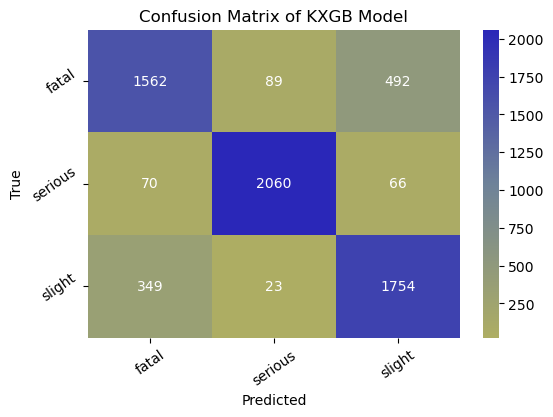

In [15]:
# plot a Confusion Matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
# Class names
class_names = ['fatal', 'serious', 'slight']
custom_cmap = LinearSegmentedColormap.from_list('custom', ["#adad63", "#6e8299", "#2a27b8"])
cm = confusion_matrix(y_test, y_pred_kxgb)
plt.figure(figsize=(6, 4))
# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap)

# Rotate the class names by 35 degrees
plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=35)
plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=35)
#plot the confusion matrix
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of KXGB Model')
plt.show()
plt.show()

In [16]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
print("Classification Report:")
print(classification_report(y_test, y_pred_kxgb, target_names=class_names))
print('Accuracy:', accuracy_score(y_test, y_pred_kxgb))
print("Recall:", recall_score(y_test, y_pred_kxgb, average='macro'))
print("Precision:", precision_score(y_test, y_pred_kxgb, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred_kxgb, average='macro'))


Classification Report:
              precision    recall  f1-score   support

       fatal       0.79      0.73      0.76      2143
     serious       0.95      0.94      0.94      2196
      slight       0.76      0.83      0.79      2126

    accuracy                           0.83      6465
   macro avg       0.83      0.83      0.83      6465
weighted avg       0.83      0.83      0.83      6465

Accuracy: 0.831554524361949
Recall: 0.8306591587064385
Precision: 0.833006793739698
F1 score: 0.8303955213161002


In [17]:
# Perform cross-validation for the best model
from sklearn.model_selection import cross_val_score
cv_scores_kxgb = cross_val_score(best_model_kxgb, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (XGBoost): {cv_scores_kxgb}")
print(f"Mean Cross-Validation Accuracy (XGBoost): {cv_scores_kxgb.mean()}")

[09:39:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.

[09:40:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.

[09:40:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.

[09:40:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.

[09:40:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.

Cross-Validation Accuracy (XGBoost): [0.83932715 0.82559938 0.83388126 0.82691936 0.8305937 ]
Mean Cross-Validation Accuracy (XGBoost): 0.8312641683802957


In [ ]:
# Saving the best model
import joblib
joblib.dump(best_model_kxgb, 'C:\\Users\\getac\\Documents\\Thesis file\\Project\\model\\best_KXGB_model4.pkl')

# 2. KLGBM Model

In [21]:
import lightgbm as lgb
# Hyperparameter Tuning using GridSearchCV for LightGBM
param_grid_klgb = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [20, 30, 40],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [100, 200, 300, 400, 500],
    'objective': ['multiclass'],
    'random_state': [42],
}

# Perform GridSearchCV with k-fold cross-validation
grid_search_klgb = GridSearchCV(
    lgb.LGBMClassifier(), 
    param_grid_klgb, 
    cv=5, 
    scoring='accuracy',
    verbose=4,
    n_jobs=-1
    
)

grid_search_klgb.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [5, 10, 15],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'num_leaves': [20, 30, 40],
                         'objective': ['multiclass'], 'random_state': [42]},
             scoring='accuracy', verbose=4)

In [22]:
# Get the best hyperparameters and the corresponding model
best_params_klgb = grid_search_klgb.best_params_
best_model_klgb = grid_search_klgb.best_estimator_

# Train the best model on the full training set
best_model_klgb.fit(X_train_resampled, y_train_resampled)

# Printing the best hyperparameters
print('The best hyperparameters are:\n', grid_search_klgb.best_params_)

The best hyperparameters are:
 {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 500, 'num_leaves': 40, 'objective': 'multiclass', 'random_state': 42}


In [23]:
# Predict on the testing set
y_pred_klgb = best_model_klgb.predict(X_test_resampled)

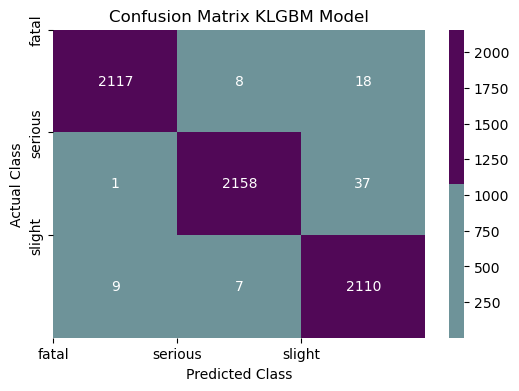

In [24]:
#Confusion Matrics
from sklearn.metrics import confusion_matrix
class_names = ['fatal', 'serious', 'slight']
cm = confusion_matrix(y_test_resampled, y_pred_klgb)
cmap_custom = sns.color_palette(["#6e9399", "#510857"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap_custom)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.xticks(ticks=[0, 1, 2], labels=class_names)
plt.yticks(ticks=[0, 1, 2], labels=class_names)
plt.title('Confusion Matrix KLGBM Model')
plt.show()

In [25]:
print("Confusion Matrix:")
print(confusion_matrix(y_test_resampled, y_pred_klgb))

Confusion Matrix:
[[2117    8   18]
 [   1 2158   37]
 [   9    7 2110]]



In [26]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
print("Classification Report:")
print(classification_report(y_test_resampled, y_pred_klgb, target_names=class_names))
print('Accuracy:', accuracy_score(y_test_resampled, y_pred_klgb))
print("Recall:", recall_score(y_test_resampled, y_pred_klgb, average='macro'))
print("Precision:", precision_score(y_test_resampled, y_pred_klgb, average='macro'))
print("F1 score:", f1_score(y_test_resampled, y_pred_klgb, average='macro'))

Classification Report:
              precision    recall  f1-score   support

       fatal       1.00      0.99      0.99      2143
     serious       0.99      0.98      0.99      2196
      slight       0.97      0.99      0.98      2126

    accuracy                           0.99      6465
   macro avg       0.99      0.99      0.99      6465
weighted avg       0.99      0.99      0.99      6465

Accuracy: 0.9876256767208044
Recall: 0.9876791386291855
Precision: 0.9876638287622129
F1 score: 0.9876306348766789


In [27]:
# Perform cross-validation for the best model
from sklearn.model_selection import cross_val_score
cv_scores_klgb = cross_val_score(best_model_klgb, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (K-LightGBM): {cv_scores_klgb}")
print(f"Mean Cross-Validation Accuracy (K-LightGBM): {cv_scores_klgb.mean()}")


Cross-Validation Accuracy (K-LightGBM): [0.98820572 0.98743233 0.98994392 0.98917037 0.98762328]
Mean Cross-Validation Accuracy (K-LightGBM): 0.9884751251962467


In [28]:
# Saving the best model
import joblib
joblib.dump(best_model_klgb, 'C:\\Users\\getac\\Documents\\Thesis file\\Project\\model\\best_KLGBM_model.pkl')


['C:\\Users\\getac\\Documents\\Thesis file\\Project\\model\\best_KLGBM_model.pkl']

# 3. KRF Model

In [30]:
# Hyperparameter Tuning using GridSearchCV for RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid_krf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_leaf': [1, 2, 4, 10],
    'min_samples_split': [2, 5, 10, 15, 100],
    'max_features': ['auto', 'log2', 'sqrt'],
}

# Perform GridSearchCV with k-fold cross-validation
grid_search_krf = GridSearchCV(
    RandomForestClassifier(), 
    param_grid_krf, 
    cv=5, 
    scoring='accuracy',
    verbose=4,
    n_jobs=-1
)
grid_search_krf.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 3000 candidates, totalling 15000 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20, 25],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4, 10],
                         'min_samples_split': [2, 5, 10, 15, 100],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='accuracy', verbose=4)

In [31]:
# Get the best hyperparameters and the corresponding model
best_params_krf = grid_search_krf.best_params_
best_model_krf = grid_search_krf.best_estimator_

# Train the best model on the full training set
best_model_krf.fit(X_train_resampled, y_train_resampled)

# Printing the best hyperparameters
print('The best hyperparameters are:\n', grid_search_krf.best_params_)

The best hyperparameters are:
 {'criterion': 'gini', 'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [32]:
# Predict on the testing set
y_pred_krf = best_model_krf.predict(X_test_resampled)

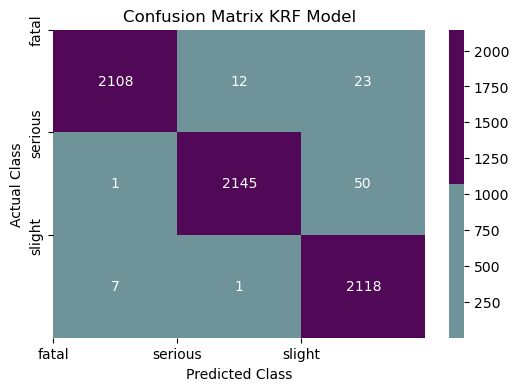

In [33]:
#Confusion Matrics
from sklearn.metrics import confusion_matrix
class_names = ['fatal', 'serious', 'slight']
cm = confusion_matrix(y_test_resampled, y_pred_krf)
cmap_custom = sns.color_palette(["#6e9399", "#510857"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap_custom)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.xticks(ticks=[0, 1, 2], labels=class_names)
plt.yticks(ticks=[0, 1, 2], labels=class_names)
plt.title('Confusion Matrix KRF Model')
plt.show()

In [34]:
print("Confusion Matrix:")
print(confusion_matrix(y_test_resampled, y_pred_krf))

Confusion Matrix:
[[2108   12   23]
 [   1 2145   50]
 [   7    1 2118]]


In [35]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
print("Classification Report:")
print(classification_report(y_test_resampled, y_pred_krf, target_names=class_names))
print('Accuracy:', accuracy_score(y_test_resampled, y_pred_krf))
print("Recall:", recall_score(y_test_resampled, y_pred_krf, average='macro'))
print("Precision:", precision_score(y_test_resampled, y_pred_krf, average='macro'))
print("F1 score:", f1_score(y_test_resampled, y_pred_krf, average='macro'))

Classification Report:
              precision    recall  f1-score   support

       fatal       1.00      0.98      0.99      2143
     serious       0.99      0.98      0.99      2196
      slight       0.97      1.00      0.98      2126

    accuracy                           0.99      6465
   macro avg       0.99      0.99      0.99      6465
weighted avg       0.99      0.99      0.99      6465

Accuracy: 0.9854601701469451
Recall: 0.9855602588925837
Precision: 0.9856256885659578
F1 score: 0.9854805253831794


In [36]:
# Perform cross-validation for the best model
cv_scores_krf = cross_val_score(best_model_krf, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (KRF): {cv_scores_krf.mean():.4f}\n")

Cross-Validation Accuracy (KRF): 0.9847



In [37]:
# Saving the best model
import joblib
joblib.dump(best_model_klgb, 'C:\\Users\\getac\\Documents\\Thesis file\\Project\\model\\best_KRF_model.pkl')

['C:\\Users\\getac\\Documents\\Thesis file\\Project\\model\\best_KRF_model.pkl']

# 4. KMLP Model

In [38]:
# Import necessary libraries for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# Hyperparameter Tuning using GridSearchCV for MLP
param_grid_kmlp = {
    'hidden_layer_sizes': [(100,), (200,), (300,)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'random_state': [42],
}

# Perform GridSearchCV with k-fold cross-validation
grid_search_kmlp = GridSearchCV(
    MLPClassifier(),
    param_grid_kmlp,
    cv=5,
    scoring='accuracy',
    verbose=4,
    n_jobs=-1
)
grid_search_kmlp.fit(X_train_resampled, y_train_resampled)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(100,), (200,), (300,)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'random_state': [42]},
             scoring='accuracy', verbose=4)

In [39]:
# Get the best hyperparameters and the corresponding model
best_params_kmlp = grid_search_kmlp.best_params_
best_model_kmlp = grid_search_kmlp.best_estimator_

# Train the best model on the full training set
best_model_kmlp.fit(X_train_resampled, y_train_resampled)

# Printing the best hyperparameters
print('The best hyperparameters for KMLP are:\n', grid_search_kmlp.best_params_)

The best hyperparameters for KMLP are:
 {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (300,), 'learning_rate': 'constant', 'random_state': 42}


In [40]:
# Predict on the testing set
y_pred_kmlp = best_model_kmlp.predict(X_test_resampled)

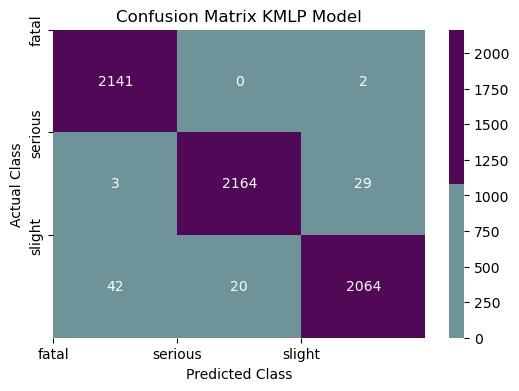

In [41]:
#Confusion Matrics
from sklearn.metrics import confusion_matrix
class_names = ['fatal', 'serious', 'slight']
cm = confusion_matrix(y_test_resampled, y_pred_kmlp)
cmap_custom = sns.color_palette(["#6e9399", "#510857"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap_custom)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.xticks(ticks=[0, 1, 2], labels=class_names)
plt.yticks(ticks=[0, 1, 2], labels=class_names)
plt.title('Confusion Matrix KMLP Model')
plt.show()

In [42]:
print("Confusion Matrix:")
print(confusion_matrix(y_test_resampled, y_pred_kmlp))

Confusion Matrix:
[[2141    0    2]
 [   3 2164   29]
 [  42   20 2064]]


In [43]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
print("Classification Report:")
print(classification_report(y_test_resampled, y_pred_kmlp, target_names=class_names))
print('Accuracy:', accuracy_score(y_test_resampled, y_pred_kmlp))
print("Recall:", recall_score(y_test_resampled, y_pred_kmlp, average='macro'))
print("Precision:", precision_score(y_test_resampled, y_pred_kmlp, average='macro'))
print("F1 score:", f1_score(y_test_resampled, y_pred_kmlp, average='macro'))

Classification Report:
              precision    recall  f1-score   support

       fatal       0.98      1.00      0.99      2143
     serious       0.99      0.99      0.99      2196
      slight       0.99      0.97      0.98      2126

    accuracy                           0.99      6465
   macro avg       0.99      0.99      0.99      6465
weighted avg       0.99      0.99      0.99      6465

Accuracy: 0.9851508120649652
Recall: 0.9851106776479824
Precision: 0.9851532701436735
F1 score: 0.9850793831165943


In [44]:
# Perform cross-validation for the best model
cv_scores_kmlp = cross_val_score(best_model_kmlp, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (KMLP): {cv_scores_kmlp.mean():.4f}\n")

Cross-Validation Accuracy (KMLP): 0.9826



# 5. KDT Model

In [45]:
# Import necessary libraries for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Hyperparameter Tuning using GridSearchCV for Decision Tree
param_grid_decision_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42],
}

# Perform GridSearchCV with k-fold cross-validation
grid_search_decision_tree = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid_decision_tree,
    cv=5,
    scoring='accuracy',
    verbose=4,
    n_jobs=-1
)
grid_search_decision_tree.fit(X_train_resampled, y_train_resampled)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'random_state': [42]},
             scoring='accuracy', verbose=4)

In [46]:
# Get the best hyperparameters and the corresponding model
best_params_decision_tree = grid_search_decision_tree.best_params_
best_model_decision_tree = grid_search_decision_tree.best_estimator_

# Train the best model on the full training set
best_model_decision_tree.fit(X_train_resampled, y_train_resampled)

# Printing the best hyperparameters
print('The best hyperparameters for Decision Tree are:\n', grid_search_decision_tree.best_params_)

The best hyperparameters for Decision Tree are:
 {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42}


In [47]:
# Predict on the testing set
y_pred_decision_tree = best_model_decision_tree.predict(X_test_resampled)

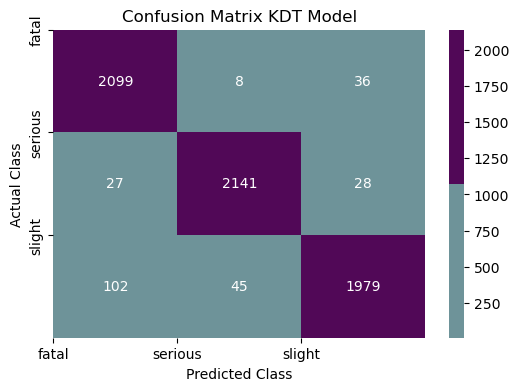

In [48]:
#Confusion Matrics
from sklearn.metrics import confusion_matrix
class_names = ['fatal', 'serious', 'slight']
cm = confusion_matrix(y_test_resampled, y_pred_decision_tree)
cmap_custom = sns.color_palette(["#6e9399", "#510857"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap_custom)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.xticks(ticks=[0, 1, 2], labels=class_names)
plt.yticks(ticks=[0, 1, 2], labels=class_names)
plt.title('Confusion Matrix KDT Model')
plt.show()

In [49]:
print("Confusion Matrix:")
print(confusion_matrix(y_test_resampled, y_pred_decision_tree))

Confusion Matrix:
[[2099    8   36]
 [  27 2141   28]
 [ 102   45 1979]]


In [50]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
print("Classification Report:")
print(classification_report(y_test_resampled, y_pred_decision_tree, target_names=class_names))
print('Accuracy:', accuracy_score(y_test_resampled, y_pred_decision_tree))
print("Recall:", recall_score(y_test_resampled, y_pred_decision_tree, average='macro'))
print("Precision:", precision_score(y_test_resampled, y_pred_decision_tree, average='macro'))
print("F1 score:", f1_score(y_test_resampled, y_pred_decision_tree, average='macro'))

Classification Report:
              precision    recall  f1-score   support

       fatal       0.94      0.98      0.96      2143
     serious       0.98      0.97      0.98      2196
      slight       0.97      0.93      0.95      2126

    accuracy                           0.96      6465
   macro avg       0.96      0.96      0.96      6465
weighted avg       0.96      0.96      0.96      6465

Accuracy: 0.9619489559164733
Recall: 0.9617595219521715
Precision: 0.9622057555616976
F1 score: 0.961735977362831


In [51]:
# Perform cross-validation for the best model
cv_scores_decision_tree = cross_val_score(best_model_decision_tree, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (KDT): {cv_scores_decision_tree.mean():.4f}\n")

Cross-Validation Accuracy (KDT): 0.9609



# 6. K2NN Model

In [52]:
# Import necessary libraries for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Hyperparameter Tuning using GridSearchCV for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2],  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Perform GridSearchCV with k-fold cross-validation
grid_search_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    scoring='accuracy',
    verbose=4,
    n_jobs=-1)
grid_search_knn.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 9], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=4)

In [53]:
# Get the best hyperparameters and the corresponding model
best_params_knn = grid_search_knn.best_params_
best_model_knn = grid_search_knn.best_estimator_

# Train the best model on the full training set
best_model_knn.fit(X_train_resampled, y_train_resampled)

# Printing the best hyperparameters
print('The best hyperparameters for K2NN are:\n', grid_search_knn.best_params_)

The best hyperparameters for K2NN are:
 {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [54]:
# Predict on the testing set
y_pred_k2nn = best_model_knn.predict(X_test_resampled)

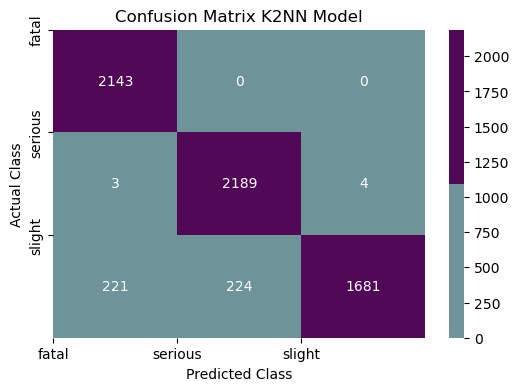

In [55]:
#Confusion Matrics
from sklearn.metrics import confusion_matrix
class_names = ['fatal', 'serious', 'slight']
cm = confusion_matrix(y_test_resampled, y_pred_k2nn)
cmap_custom = sns.color_palette(["#6e9399", "#510857"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap_custom)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.xticks(ticks=[0, 1, 2], labels=class_names)
plt.yticks(ticks=[0, 1, 2], labels=class_names)
plt.title('Confusion Matrix K2NN Model')
plt.show()

In [56]:
print("Confusion Matrix:")
print(confusion_matrix(y_test_resampled, y_pred_k2nn))

Confusion Matrix:
[[2143    0    0]
 [   3 2189    4]
 [ 221  224 1681]]


In [57]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
print("Classification Report:")
print(classification_report(y_test_resampled, y_pred_k2nn, target_names=class_names))
print('Accuracy:', accuracy_score(y_test_resampled, y_pred_k2nn))
print("Recall:", recall_score(y_test_resampled, y_pred_k2nn, average='macro'))
print("Precision:", precision_score(y_test_resampled, y_pred_k2nn, average='macro'))
print("F1 score:", f1_score(y_test_resampled, y_pred_k2nn, average='macro'))

Classification Report:
              precision    recall  f1-score   support

       fatal       0.91      1.00      0.95      2143
     serious       0.91      1.00      0.95      2196
      slight       1.00      0.79      0.88      2126

    accuracy                           0.93      6465
   macro avg       0.94      0.93      0.93      6465
weighted avg       0.94      0.93      0.93      6465

Accuracy: 0.9300850734725444
Recall: 0.9291663739368196
Precision: 0.9367203509320939
F1 score: 0.9274654721735347


In [58]:
# Perform cross-validation for the best model
cv_scores_k2nn = cross_val_score(best_model_knn, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (K2NN): {cv_scores_k2nn.mean():.4f}\n")

Cross-Validation Accuracy (K2NN): 0.9206



# 6. Staking

In [12]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import xgboost as xgb
import numpy as np

# Define base estimators
base_estimators = [
    ('dt', DecisionTreeClassifier()),
    ('ada', AdaBoostClassifier(random_state=42)),
    ('knn', KNeighborsClassifier())
]

# Define the stacking classifier
stacking_classifier = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression()
)

# Define hyperparameter grid
param_dist = {
    'dt__max_depth': [None, 10, 20, 30],
    'dt__min_samples_split': [2, 5, 10],
    'ada__n_estimators': [50, 100, 200],
    'ada__learning_rate': [0.01, 0.1, 1.0],
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance']
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=stacking_classifier,
    param_distributions=param_dist,
    n_iter=20,  # Reduce the number of iterations
    cv=5,
    scoring='accuracy',
    verbose=5,
    n_jobs=1,  # Use fewer parallel jobs
    random_state=42
)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Train the best model on the full training set
best_model.fit(X_train, y_train)

# Predictions
stacking_predictions = best_model.predict(X_test)

# Evaluate models
stacking_score = accuracy_score(y_test, stacking_predictions)
stacking_precision = precision_score(y_test, stacking_predictions, average='weighted')
stacking_recall = recall_score(y_test, stacking_predictions, average='weighted')
stacking_f1_score = f1_score(y_test, stacking_predictions, average='weighted')

# Confusion Matrix
stacking_conf_matrix = confusion_matrix(y_test, stacking_predictions)

print("\nStacking Metrics:")
print("Stacking Accuracy:", stacking_score)
print("Precision:", stacking_precision)
print("Recall:", stacking_recall)
print("F1-score:", stacking_f1_score)
print("Confusion Matrix:")
print(stacking_conf_matrix)

# Print the best hyperparameters
print('The best hyperparameters for the stacking model are:\n', best_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ada__learning_rate=1.0, ada__n_estimators=200, dt__max_depth=30, dt__min_samples_split=2, knn__n_neighbors=7, knn__weights=distance;, score=0.980 total time=  27.6s
[CV 2/5] END ada__learning_rate=1.0, ada__n_estimators=200, dt__max_depth=30, dt__min_samples_split=2, knn__n_neighbors=7, knn__weights=distance;, score=0.981 total time=  24.4s
[CV 3/5] END ada__learning_rate=1.0, ada__n_estimators=200, dt__max_depth=30, dt__min_samples_split=2, knn__n_neighbors=7, knn__weights=distance;, score=0.980 total time=  23.8s
[CV 4/5] END ada__learning_rate=1.0, ada__n_estimators=200, dt__max_depth=30, dt__min_samples_split=2, knn__n_neighbors=7, knn__weights=distance;, score=0.978 total time=  24.6s
[CV 5/5] END ada__learning_rate=1.0, ada__n_estimators=200, dt__max_depth=30, dt__min_samples_split=2, knn__n_neighbors=7, knn__weights=distance;, score=0.981 total time=  24.1s
[CV 1/5] END ada__learning_rate=0.1, ada__n_esti

[CV 2/5] END ada__learning_rate=0.1, ada__n_estimators=50, dt__max_depth=30, dt__min_samples_split=5, knn__n_neighbors=3, knn__weights=distance;, score=0.983 total time=   7.3s
[CV 3/5] END ada__learning_rate=0.1, ada__n_estimators=50, dt__max_depth=30, dt__min_samples_split=5, knn__n_neighbors=3, knn__weights=distance;, score=0.982 total time=   7.3s
[CV 4/5] END ada__learning_rate=0.1, ada__n_estimators=50, dt__max_depth=30, dt__min_samples_split=5, knn__n_neighbors=3, knn__weights=distance;, score=0.979 total time=   7.2s
[CV 5/5] END ada__learning_rate=0.1, ada__n_estimators=50, dt__max_depth=30, dt__min_samples_split=5, knn__n_neighbors=3, knn__weights=distance;, score=0.983 total time=   7.3s
[CV 1/5] END ada__learning_rate=1.0, ada__n_estimators=200, dt__max_depth=10, dt__min_samples_split=5, knn__n_neighbors=7, knn__weights=distance;, score=0.981 total time=  24.0s
[CV 2/5] END ada__learning_rate=1.0, ada__n_estimators=200, dt__max_depth=10, dt__min_samples_split=5, knn__n_neig

[CV 3/5] END ada__learning_rate=0.01, ada__n_estimators=50, dt__max_depth=30, dt__min_samples_split=10, knn__n_neighbors=5, knn__weights=distance;, score=0.981 total time=   7.3s
[CV 4/5] END ada__learning_rate=0.01, ada__n_estimators=50, dt__max_depth=30, dt__min_samples_split=10, knn__n_neighbors=5, knn__weights=distance;, score=0.978 total time=   7.3s
[CV 5/5] END ada__learning_rate=0.01, ada__n_estimators=50, dt__max_depth=30, dt__min_samples_split=10, knn__n_neighbors=5, knn__weights=distance;, score=0.981 total time=   7.3s
[CV 1/5] END ada__learning_rate=0.01, ada__n_estimators=50, dt__max_depth=None, dt__min_samples_split=5, knn__n_neighbors=7, knn__weights=uniform;, score=0.980 total time=   7.4s
[CV 2/5] END ada__learning_rate=0.01, ada__n_estimators=50, dt__max_depth=None, dt__min_samples_split=5, knn__n_neighbors=7, knn__weights=uniform;, score=0.980 total time=   7.3s
[CV 3/5] END ada__learning_rate=0.01, ada__n_estimators=50, dt__max_depth=None, dt__min_samples_split=5, 